In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from collections import Counter
from matplotlib.pyplot import pie, axis, show
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext , functions
from pyspark.sql.functions import array_contains,count,countDistinct,col
from folium import plugins



In [3]:
spark = SparkSession.builder \
.appName('ReadFromParquet') \
.master('local[6]') \
.getOrCreate()

In [4]:
spark

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Data Feature

## osmWay

In [6]:
sqlContext.setConf("spark.sql.parquet.binaryAsString","true")
osmWay = sqlContext.read.parquet("../data/20190531-hungary.osm.pbf.way.parquet")
osmWay = osmWay.select('id','tags','nodes')
osmWay.createOrReplaceTempView("osmWay")




In [7]:
osmWay.printSchema()

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = true)
 |    |    |-- nodeId: long (nullable = true)



In [8]:
osmWay.head()

Row(id=3175810, tags=[Row(key='highway', value='residential'), Row(key='name', value='Honvéd utca')], nodes=[Row(index=0, nodeId=15231786), Row(index=1, nodeId=1310148452), Row(index=2, nodeId=1310021025), Row(index=3, nodeId=1310020985), Row(index=4, nodeId=5766745506), Row(index=5, nodeId=1310020988), Row(index=6, nodeId=1310021030), Row(index=7, nodeId=1310021038), Row(index=8, nodeId=1310021044), Row(index=9, nodeId=1309949162), Row(index=10, nodeId=1309949099), Row(index=11, nodeId=1282709263), Row(index=12, nodeId=5766742402), Row(index=13, nodeId=1234760030)])

In [9]:
osmWay.show(5)

+-------+--------------------+--------------------+
|     id|                tags|               nodes|
+-------+--------------------+--------------------+
|3175810|[[highway, reside...|[[0, 15231786], [...|
|3175943|[[highway, reside...|[[0, 15234255], [...|
|3175983|[[highway, reside...|[[0, 15232076], [...|
|3192356|[[highway, second...|[[0, 1259548666],...|
|3212111|[[highway, second...|[[0, 15475952], [...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [10]:
osmWay.count()

2509434

## osmNode

In [11]:
osmNode = sqlContext.read.parquet("../data/20190531-hungary.osm.pbf.node.parquet")
osmNode = osmNode.select('tags', 'latitude','longitude')
osmNode.createOrReplaceTempView("osmNode")

In [12]:
osmNode.printSchema()

root
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [13]:
osmNode.head()

Row(tags=[], latitude=47.5135549, longitude=19.047102000000002)

In [14]:
osmNode.show(5)

+----+------------------+------------------+
|tags|          latitude|         longitude|
+----+------------------+------------------+
|  []|        47.5135549|19.047102000000002|
|  []|        47.5135409|19.058013900000002|
|  []|        47.5146097|19.058831700000002|
|  []|        47.5166629|        19.0613926|
|  []|47.514618000000006|        19.0435418|
+----+------------------+------------------+
only showing top 5 rows



In [15]:
osmNode.count()

17916477

In [16]:
sqlContext.sql("SELECT tags,latitude, longitude FROM osmNode \
WHERE tags[0].key='amenity' AND tags[0].value='taxi'").show()

+--------------------+------------------+------------------+
|                tags|          latitude|         longitude|
+--------------------+------------------+------------------+
|[[amenity, taxi],...|        47.5470381|         19.028375|
|   [[amenity, taxi]]|        47.4982064|        19.0704767|
|   [[amenity, taxi]]|47.496360800000005|19.070999500000003|
|   [[amenity, taxi]]|47.507562500000006|        19.0729668|
|   [[amenity, taxi]]|47.499501300000006|        19.0646431|
|   [[amenity, taxi]]|47.782211200000006|        19.1324766|
|   [[amenity, taxi]]|        47.5420646|        19.1225384|
|   [[amenity, taxi]]|        48.2466887|        20.6166425|
|   [[amenity, taxi]]|46.353023300000004|        17.7953511|
|   [[amenity, taxi]]|46.075580200000005|        18.2048794|
|[[amenity, taxi],...|47.511096200000004|19.080156300000002|
|   [[amenity, taxi]]|        47.9000818|        20.3767527|
|   [[amenity, taxi]]|46.370169600000004|18.149269800000003|
|   [[amenity, taxi]]|47

## osmRelation

In [17]:
osmRelation = sqlContext.read.parquet("../data/20190531-hungary.osm.pbf.relation.parquet")
osmRelation = osmRelation.select('id','tags','members')
osmRelation.createOrReplaceTempView("osmRelation")

In [18]:
osmRelation.printSchema()

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- members: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- role: string (nullable = true)
 |    |    |-- type: string (nullable = true)



In [19]:
osmRelation.head()

Row(id=11772, tags=[Row(key='addr:city', value='Budapest'), Row(key='addr:housenumber', value='9'), Row(key='addr:postcode', value='1051'), Row(key='addr:street', value='Széchenyi István tér'), Row(key='building', value='yes'), Row(key='club', value='cinema'), Row(key='email', value='info@titkarsag.mta.hu'), Row(key='name', value='Magyar Tudományos Akadémia'), Row(key='name:de', value='Ungarische Akademie der Wissenschaften'), Row(key='name:en', value='Hungarian Academy of Sciences'), Row(key='office', value='government'), Row(key='phone', value='+36 1 4116100'), Row(key='short_name', value='MTA'), Row(key='tourism', value='attraction'), Row(key='type', value='multipolygon'), Row(key='website', value='https://mta.hu/'), Row(key='wikidata', value='Q265058'), Row(key='wikipedia', value='hu:Magyar Tudományos Akadémia')], members=[Row(id=24026306, role='inner', type='Way'), Row(id=24321932, role='outer', type='Way'), Row(id=241012663, role='outer', type='Way'), Row(id=241012664, role='oute

In [20]:
osmRelation.show(5)

+-----+--------------------+--------------------+
|   id|                tags|             members|
+-----+--------------------+--------------------+
|11772|[[addr:city, Buda...|[[24026306, inner...|
|11832|[[building, yes],...|[[24035233, outer...|
|11898|[[building, offic...|[[24345565, inner...|
|12697|[[addr:city, Buda...|[[24260435, outer...|
|12939|[[addr:conscripti...|[[24320909, outer...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [21]:
osmRelation.count()

12983

# Data Explore

### Distribution of Different Type of Highway

In [22]:
highway = sqlContext.sql("SELECT osmWay.tags[0].value as Value,COUNT(osmWay.tags[0].value) as Count FROM osmWay WHERE tags[0].key='highway' GROUP BY osmWay.tags[0].value")
highway.count()

38

In [23]:
foundDatas = []
allRows = sqlContext.sql("SELECT id,tags FROM osmWay")
for row in allRows.collect():
    for item in row["tags"]:
        if item.key == "highway":
            foundDatas.append(item.value)
counter = Counter(foundDatas)
result = [(counter[key], key) for key in counter]

In [24]:
highwaydf = pd.DataFrame(list(result),columns=['Count','Value'])
highway = highwaydf.sort_values(by=['Count'],ascending=False)

In [25]:
highway = highway.head()
highway

,Count,Value
8,236057,track
0,167032,residential
4,104977,service
6,61163,footway
12,42369,path


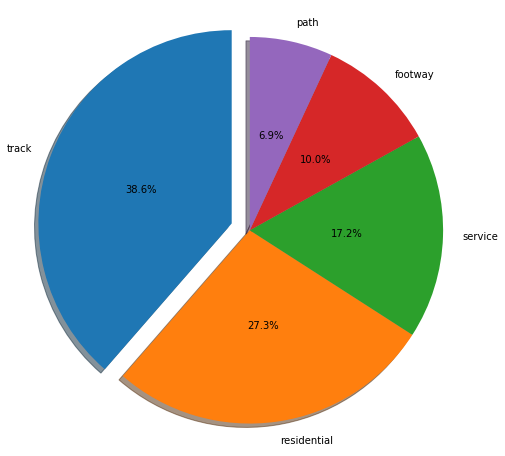

In [26]:
plt.pie(
    highway['Count'],
    labels=highway['Value'],
    shadow=True,
    explode=(0.1, 0, 0, 0, 0),
    startangle=90,
    autopct='%1.1f%%',
    pctdistance = 0.5,
)

plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(8,8)


### The Most Common Amenities

In [27]:
amenities = sqlContext.sql("SELECT osmWay.tags[0].value as Value,COUNT(osmWay.tags[0].value) as Count FROM osmWay WHERE tags[0].key='amenity' GROUP BY osmWay.tags[0].value")
amenities.count()

115

In [28]:
foundDatas = []
allRows = sqlContext.sql("SELECT id,tags FROM osmWay")
for row in allRows.collect():
    for item in row["tags"]:
        if item.key == "amenity":
            foundDatas.append(item.value)
counter = Counter(foundDatas)
result = [(counter[key], key) for key in counter]

In [29]:
amenitydf = pd.DataFrame(list(result),columns=['Count','Value'])
amenity = amenitydf.sort_values(by=['Count'],ascending=False)

In [30]:
amenitiesdf = amenity.sort_values(by=['Count'],ascending=False)
amenitiesdf.head()

,Count,Value
0,13353,parking
13,5270,place_of_worship
2,1900,school
16,1002,restaurant
25,917,kindergarten


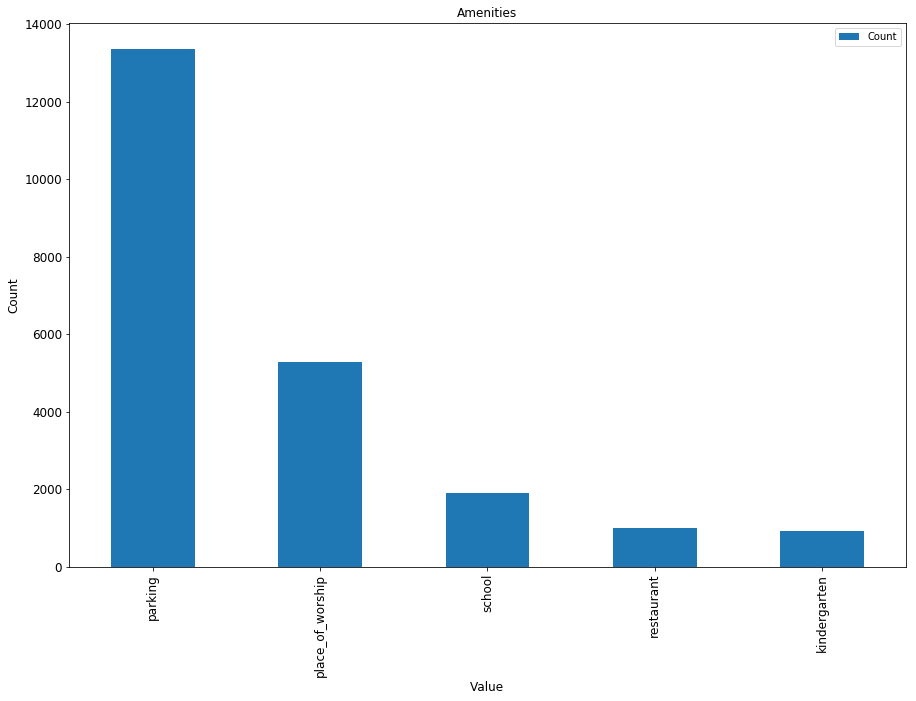

In [31]:
ax = amenitiesdf[:5].plot(kind='bar',x='Value', y='Count',title ="Amenities", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### Number of Taxi Stop and Location Each of Them

In [32]:
taxiLocation = sqlContext.sql("SELECT latitude,longitude FROM osmNode") \
.where((array_contains(osmNode.tags.key, 'amenity') & (array_contains(osmNode.tags.value,'taxi'))))

taxiLocation.take(5)


[Row(latitude=47.5470381, longitude=19.028375),
 Row(latitude=47.4982064, longitude=19.0704767),
 Row(latitude=47.496360800000005, longitude=19.070999500000003),
 Row(latitude=47.507562500000006, longitude=19.0729668),
 Row(latitude=47.499501300000006, longitude=19.0646431)]

In [33]:
taxiLocation.count()

160

In [34]:
taxiLocation = sqlContext.sql("SELECT latitude,longitude FROM osmNode \
WHERE tags[0].key='amenity' AND tags[0].value='taxi'").toPandas()

In [35]:
taxidf = pd.DataFrame(data=taxiLocation)
taxidf.head()

,latitude,longitude
0,47.547038,19.028375
1,47.498206,19.070477
2,47.496361,19.071000
3,47.507563,19.072967
4,47.499501,19.064643


In [36]:
taxiMap = folium.Map([taxiLocation.latitude[0], taxiLocation.longitude[0]], zoom_start=7)

In [37]:
for index, row in taxidf.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row[['latitude','longitude']],
                        fill_color="#e4d93d",
                       ).add_to(taxiMap)
taxiMap